Importing required libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [0]:
from keras.callbacks import ModelCheckpoint

Importing CIFAR10 dataset

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


Plotting one sample image from each of the 10 classes in CIFAR10

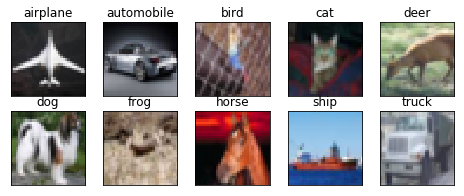

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Function to plot :

- model accuracy vs epoch  
- loss vs epoch  

Thus plotting the history of change in accuracy and loss against the epoch as the model was training



In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Defining a function to calculate model accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Converting class labels to binary class labels using to_categorical

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Rewriting my model from assignment 6A using keras functional APIs.

- x2 is Normal Convolution  
- x5 and x6 constitute Spatially Separable Convolution  
- x9 is Depthwise Separable Convolution
- x12, x13, x14 is Grouped Convolution where x12 uses 3x3 kernel and x13 uses 5x5 kernel    
- x22, x23, x24 is Grouped Convolution where x22 uses 3x3 with dialation=1 and x23 uses 5x5 kernel with dialation=2


In [0]:
from keras.layers import Input, SeparableConv2D, Concatenate
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Flatten, Add, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

x1 = Input(shape=(32, 32, 3))

x2 = Conv2D(32, kernel_size=3, border_mode='same')(x1)
x3 = BatchNormalization()(x2)
x4 = Activation('relu')(x3) #32x32x32 (Output resolution)

x5 = Conv2D(64, kernel_size=(3,1))(x4)
x6 = Conv2D(64, kernel_size=(1,3))(x5)
x7 = BatchNormalization()(x6)
x8 = Activation('relu')(x7) #30x30x64

x9 = SeparableConv2D(128, kernel_size=(3,3))(x8)
x10 = BatchNormalization()(x9) 
x11 = Activation('relu')(x10) #28x28x128

x12 = Conv2D(128, kernel_size=(3,3), padding='same')(x11) #28x28x128
x13 = Conv2D(128, kernel_size=(5,5), padding='same')(x11) #28x28x128
x14 = Concatenate(axis = 3)([x12, x13]) #28x28x256
x15 = BatchNormalization()(x14) 
x16 = Activation('relu')(x15)

x17 = MaxPooling2D(pool_size=(2, 2))(x16) #14x14x256
x18 = Conv2D(32, kernel_size=(1,1))(x17) #14x14x32
x19 = BatchNormalization()(x18) 
x20 = Activation('relu')(x19)

x21 = Dropout(0.05)(x20)

x22 = Conv2D(32, kernel_size=(3,3), padding='same', dilation_rate=1)(x21) #14x14x32
x23 = Conv2D(32, kernel_size=(3,3), padding='same', dilation_rate=2)(x21) #14x14x32
x24 = Concatenate(axis = 3)([x22, x23]) #14x14x64
x25 = BatchNormalization()(x24) 
x26 = Activation('relu')(x25)

x27 = Conv2D(128, kernel_size=3)(x26)
x28 = BatchNormalization()(x27)
x29 = Activation('relu')(x28) #12x12x128

x30 = Conv2D(256, kernel_size=3)(x29)
x31 = BatchNormalization()(x30)
x32 = Activation('relu')(x31) #10x10x256

x33 = Conv2D(10, kernel_size=1)(x32) #10x10x10
x34 = BatchNormalization()(x33)
x35 = Activation('relu')(x34)

x36 = Conv2D(10, kernel_size=10)(x35) #1x1x10
x37 = Activation('relu')(x36)
flat = Flatten()(x37)

output = Activation('softmax')(flat)

model = Model(inputs=x1, outputs=output)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=3, padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 32, 32, 32)   128         conv2d_23[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 32, 32, 32)   0           batch_normalization_17[0][0]     
____________________________________________________________________________________________

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab_Models/'

Mounted at /content/gdrive


Using 'adam' as the optimiser and 'categorical_crossentropy' as the loss function

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(root_path+'model_assignment_6b.h5', save_best_only=True,monitor='val_acc')

- Using a learning rate scheduler and ImageDataGenerator for image augmentation
- Training the model for 50 epochs with a batch size of 128

390/390 [==============================] - 78s 199ms/step - loss: 1.7102 - acc: 0.2860 - val_loss: 1.9190 - val_acc: 0.2624
Epoch 18/50

Epoch 00018: LearningRateScheduler setting learning rate to 0.0004670715.
Epoch 18/50

Epoch 00018: LearningRateScheduler setting learning rate to 0.0004670715.
390/390 [==============================] - 77s 198ms/step - loss: 1.6978 - acc: 0.2862 - val_loss: 1.8820 - val_acc: 0.2725
Epoch 19/50

Epoch 00019: LearningRateScheduler setting learning rate to 0.0004449718.
  1/390 [..............................] - ETA: 1:17 - loss: 1.6236 - acc: 0.3125Epoch 19/50

Epoch 00019: LearningRateScheduler setting learning rate to 0.0004449718.
390/390 [==============================] - 77s 198ms/step - loss: 1.6816 - acc: 0.2888 - val_loss: 1.9645 - val_acc: 0.2559
Epoch 20/50

Epoch 00020: LearningRateScheduler setting learning rate to 0.000424869.
  1/390 [..............................] - ETA: 1:14 - loss: 1.5799 - acc: 0.3203Epoch 20/50

Epoch 00020: Learni

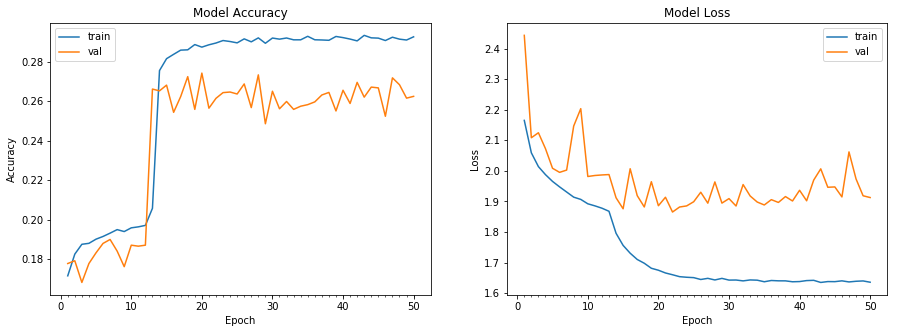

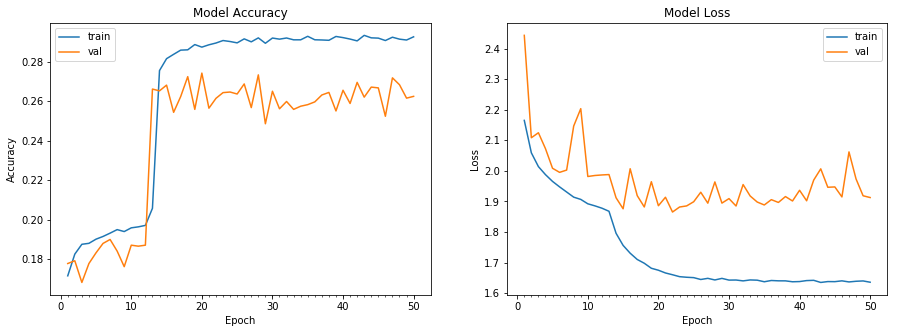

Accuracy on test data is: 26.25
Accuracy on test data is: 26.25


In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1),checkpoint])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))